In [2]:
import pandas as pd
import numpy as np
from selenobot.utils import DATA_DIR, dataframe_from_ko, dataframe_from_fasta
import os
from scipy.stats import linregress
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


%load_ext autoreload
%autoreload 2

In [3]:
# Load in the KEGG annotations, keeping only the first entry for each sequence. 
sec_ko_df = dataframe_from_ko(os.path.join(DATA_DIR, 'sec.fasta.ko'), parse_header=True).drop_duplicates('id', keep='first')
sec_truncated_ko_df = dataframe_from_ko(os.path.join(DATA_DIR, 'sec_truncated.fasta.ko'), parse_header=True).drop_duplicates('id', keep='first')

print(len(sec_ko_df), 'non-truncated selenoproteins were successfully annotated.')
print(len(sec_truncated_ko_df), 'truncated selenoproteins were successfully annotated.')

18694 non-truncated selenoproteins were successfully annotated.
13953 truncated selenoproteins were successfully annotated.


In [4]:
# Load in the truncated and non-truncated selenoproteins.
sec_df = dataframe_from_fasta(os.path.join(DATA_DIR, 'sec.fasta'))
sec_truncated_df = dataframe_from_fasta(os.path.join(DATA_DIR, 'sec_truncated.fasta'))

print(len(sec_df), 'total selenoproteins.')

18988 total selenoproteins.


In [5]:
# Remove the [1] tag from the truncated selenoproteins.
sec_truncated_ko_df['id'] = sec_truncated_ko_df['id'].str.replace('[1]', '')
sec_truncated_df['id'] = sec_truncated_df['id'].str.replace('[1]', '')

What questions can we ask about the differences between annotations of truncated versus non-truncated selenoproteins?
1. How many of the non-truncated selenoproteins are annotated the same way as their truncated counterparts?
2. Are proteins with smaller `n_trunc` values (i.e. proteins which have been truncated less) more likely to be annotated, or have correct annotations? Note that I am assuming the full-length annotations are the "correct" annotations. 
3. Which KO groups are most represented amongst truncated selenoprotein predictions? Are these the same as the KO groups of non-truncated selenoproteins?

In [6]:
# Create a DataFrame with all of the information I care about. 
df = sec_truncated_df.merge(sec_ko_df[['id', 'ko']], on='id', how='outer')
df['full_length'] = sec_df.set_index('id').loc[df['id'].values].seq.apply(len).values # Get the original lengths of each protein.
df = df.rename(columns={'ko':'ko_from_full_length'})
df = df.merge(sec_truncated_ko_df[['id', 'ko']], on='id', how='outer')
df = df.rename(columns={'ko':'ko_from_truncated'})
df.n_trunc = df.n_trunc.apply(pd.to_numeric) # Convert n_trunc to numbers. These values are read in as strings.  
df['p_trunc'] = df.n_trunc / df.full_length # Compute the percentage of each protein which has been truncated.
df.head()

,n_sec,id,n_trunc,seq,ko_from_full_length,full_length,ko_from_truncated,p_trunc
0,1,A0A010YS46,77,MVYKILHYINQFFAGVGGEDKADFEPKAVSGAMGPGVQLEKLFGGK...,K10672,425,K10672,0.181176
1,1,A0A010YTV1,67,MPDIRESIKQAYTEAVSRGGEETLSISDMTKDNYDEETLRDLPVQT...,K07755,253,K07755,0.264822
2,1,A0A023SCV1,126,MYEFSAKDIDGNEVSLEKYKDHVCIVVNVASK,K05361,158,K05361,0.797468
3,1,A0A060CZ14,152,MAKFYDLTAKLLTGEMFNFSSLQGKVVLIENVASL,K00432,187,K00432,0.812834
4,1,A0A060IG47,135,MPRQAASRLVVGEGEGPPGASGPAATMFRSLPLHSLRLCAQTASCL...,K07754,304,K07754,0.444079


In [7]:
# Some checks of the DataFrame...
assert np.all(df.n_trunc.values <= df.full_length), 'Some of the n_trunc values are greater than the full sequence length.'
assert np.all(df.p_trunc.values <= 1), 'Some of the p_trunc values are greater than 1.'

In [8]:
df_both_annotated = df.dropna(axis=0)
n_matching_annotations = (df_both_annotated.ko_from_full_length == df_both_annotated.ko_from_truncated).sum()
print(np.round(n_matching_annotations / len(df_both_annotated) * 100, 2), 'percent of annotations based on truncated sequences are "correct".')

81.14 percent of annotations based on truncated sequences are "correct".


In [9]:
# Is there a correllation between size of the truncation and whether or not the truncated protein is annotated?
df['bin_label'] = pd.qcut(df.n_trunc, 100, duplicates='drop')

success_rates, mean_n_truncs, mean_p_truncs = [], [], []
# Now we can group by bin labels and compute the number of annotations. 
for bin_label, bin_df in df.groupby('bin_label'):
    # success_rate = len(bin_df[['ko_from_truncated']].dropna(axis=0)) / len(bin_df) # Get the percentage of instances in the bin with successful annotations from the truncated protein.
    bin_df = bin_df[['ko_from_truncated', 'ko_from_full_length', 'n_trunc', 'p_trunc']].dropna(axis=0)
    success_rate = np.sum(bin_df.ko_from_full_length.values == bin_df.ko_from_truncated.values) / len(bin_df)
    mean_n_trunc = bin_df.n_trunc.mean().item() # Get the mean truncation size of sequences in the bin. 
    mean_p_trunc = bin_df.p_trunc.mean().item() # Get the mean truncation size of sequences in the bin. 
    
    success_rates.append(success_rate)
    mean_n_truncs.append(mean_n_trunc)
    mean_p_truncs.append(mean_p_trunc)

/tmp/ipykernel_119911/3689726689.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin_label, bin_df in df.groupby('bin_label'):


In [10]:
# Fit a linear regression model to the data. 
# linreg = linregress(mean_n_truncs, success_rates)
linreg = linregress(mean_p_truncs, success_rates)
x_vals = np.linspace(min(mean_p_truncs), max(mean_p_truncs), 100)
y_vals = linreg.slope * x_vals + linreg.intercept

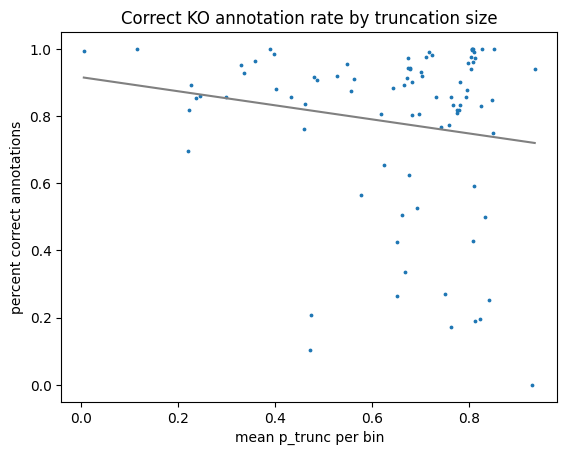

In [11]:
fig, ax = plt.subplots()

ax.plot(x_vals, y_vals, c='gray')
ax.scatter(mean_p_truncs, success_rates, s=3)
ax.set_xlabel('mean p_trunc per bin')
ax.set_ylabel('percent correct annotations')
ax.set_title('Correct KO annotation rate by truncation size')

plt.show()

In [12]:
# Which KO groups are correctly-annotated the most frequently?

ko_plot_df = []

for ko, ko_df in df.groupby('ko_from_full_length'):
    if ko is None:
        continue
    row = dict()
    row['ko'] = ko
    row['n_annotated'] = len(ko_df[['ko_from_truncated']].dropna(axis=0))
    row['n_correct'] = np.sum(ko_df.ko_from_truncated.str.match(ko))
    row['p_correct'] = row['n_correct'] / len(ko_df)
    row['p_annotated'] = row['n_annotated'] / len(ko_df)
    row['n_total'] = len(ko_df)
    row['n_trunc_mean'] = np.mean(ko_df.n_trunc.values)
    
    assert np.all(ko_df.p_trunc.values <= 1), 'Some of the p_trunc values are greater than 1.'
    row['p_trunc_mean'] = np.mean(ko_df.p_trunc.values)
    row['p_trunc_err'] = np.std(ko_df.p_trunc.values) / np.sqrt(len(ko_df))
    row['n_trunc_err'] = np.std(ko_df.n_trunc.values) / np.sqrt(len(ko_df))
    ko_plot_df.append(row)

ko_plot_df = pd.DataFrame(ko_plot_df)

# Compute percentages for each category. 
ko_plot_df['p_annotated'] = ko_plot_df.n_annotated / ko_plot_df.n_total
ko_plot_df['p_correct'] = ko_plot_df.n_correct / ko_plot_df.n_total

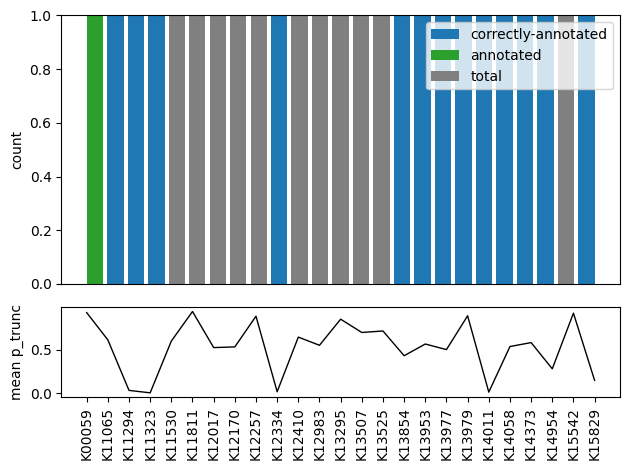

In [13]:
fig = plt.figure()
grid = GridSpec(2, 1, height_ratios=[3, 1])

ax = fig.add_subplot(grid[0, 0])
n = 25 
x_vals = np.arange(n)

# ko_plot_df = ko_plot_df.sort_values('n_total', ascending=False)[:n] # Plot the n most-represented KO groups. 
ko_plot_df = ko_plot_df.sort_values('n_total')[:n] # Plot the n most-represented KO groups. 

# ax[0].bar(x_vals, ko_plot_df.p_correct)
# ax[0].bar(x_vals, ko_plot_df.p_annotated - ko_plot_df.p_correct, bottom=ko_plot_df.p_correct)
# ax.bar(x_vals, np.ones(n) - (ko_plot_df.p_annotated + ko_plot_df.p_correct), bottom=(ko_plot_df.p_annotated + ko_plot_df.p_correct), color='gray')

ax.bar(x_vals, ko_plot_df.n_correct)
ax.bar(x_vals, ko_plot_df.n_annotated - ko_plot_df.n_correct, bottom=ko_plot_df.n_correct, color='tab:green')
ax.bar(x_vals, ko_plot_df.n_total - (ko_plot_df.n_annotated), bottom=ko_plot_df.n_annotated, color='gray')
ax.set_xticks([])
ax.legend(['correctly-annotated', 'annotated', 'total'])
ax.set_ylabel('count')

ax = fig.add_subplot(grid[1, 0])
# ax.errorbar(x_vals, ko_plot_df.n_trunc_mean, yerr=ko_plot_df.n_trunc_err, color='black', lw=1)
ax.errorbar(x_vals, ko_plot_df.p_trunc_mean, yerr=ko_plot_df.p_trunc_err, color='black', lw=1)
ax.set_xticks(x_vals, labels=ko_plot_df.ko[:n], rotation=90)
ax.set_ylabel('mean p_trunc')

plt.tight_layout()
plt.show()

In [15]:
print(list(ko_plot_df.ko.values))

['K00059', 'K11065', 'K11294', 'K11323', 'K11530', 'K11811', 'K12017', 'K12170', 'K12257', 'K12334', 'K12410', 'K12983', 'K13295', 'K13507', 'K13525', 'K13854', 'K13953', 'K13977', 'K13979', 'K14011', 'K14058', 'K14373', 'K14954', 'K15542', 'K15829']
